In [1]:
from imblearn.over_sampling import SMOTE
import sklearn as sk
from sklearn.neural_network import MLPClassifier
import random as rnd
import matplotlib.pyplot as plt
import joblib

In [2]:
%run -i "src/data_preproc.py"

Reading file: orbis_active_be.xlsx ...
Reading file: orbis_active_de.xlsx ...
Reading file: orbis_active_es.xlsx ...
Reading file: orbis_active_fin.xlsx ...
Reading file: orbis_active_fra.xlsx ...
Reading file: orbis_active_it.xlsx ...
Reading file: orbis_active_no.xlsx ...
Reading file: orbis_active_rest.xlsx ...
Reading file: orbis_active_se.xlsx ...
Reading file: orbis_default.xlsx ...


In [3]:
df['country'].groupby([df['country']]).count().sort_values(ascending=False)

country
IT    35458
SE    34660
ES    33540
FR    33117
DE    33100
DK    32246
FI    24967
NO    21206
NL     4676
AT     3080
IS     2364
BE      640
CY       42
LU        1
Name: country, dtype: int64

In [4]:
# NAs share among original variables
(df.loc[:, ~df.columns.str.contains('ratio|ch|sector_')].isna().sum() / df.shape[0]).sort_values(ascending=False)



revenue_lag     0.198200
revenue         0.171048
lt_debt         0.079032
cash            0.045801
pnl_lag         0.032853
ebit_lag        0.032235
assets_lag      0.020367
capital         0.010818
sector          0.005318
ebit            0.000120
fixed_assets    0.000012
assets          0.000004
assets_log      0.000004
CY              0.000000
FR              0.000000
IS              0.000000
SE              0.000000
AT              0.000000
BE              0.000000
NL              0.000000
NO              0.000000
IT              0.000000
Inactive        0.000000
FI              0.000000
ES              0.000000
DE              0.000000
DK              0.000000
country         0.000000
curr_liab       0.000000
curr_assets     0.000000
pnl             0.000000
last_year       0.000000
LU              0.000000
dtype: float64

In [5]:
split_share = 0.8

rnd.seed(1)
train_id = rnd.sample(range(df.shape[0]), round(df.shape[0] * split_share))

train_df = df.drop(['country', 'last_year', 'sector'], axis=1).loc[train_id]
test_df  = df.drop(['country', 'last_year', 'sector'], axis=1).loc[~np.isin(list(range(df.shape[0])), train_id)]

In [6]:

# univariate imputing with train dataset median of given variable. 
for variable in train_df.loc[:, train_df.apply(lambda x: any(x.isna()))].columns:
    train_df.loc[train_df[variable].isna(), variable] = train_df[variable].median()
    test_df.loc[test_df[variable].isna(), variable] = test_df[variable].median()

# idea to implement: multivariate LM imputing based on no NAs variable

In [7]:
X_train_sm, y_train_sm = SMOTE(random_state=1).fit_resample(train_df.loc[:,~np.isin(train_df.columns, 'Inactive')], train_df['Inactive'])

In [8]:
rnd.seed(1)
os_indexes = rnd.choices(list(train_df[train_df.Inactive == 1].index), k = np.sum(train_df.Inactive == 0) - np.sum(train_df.Inactive == 1))
us_indexes = rnd.sample(list(train_df[train_df.Inactive == 0].index), k = np.sum(train_df.Inactive == 1))

train_df_os = pd.concat([train_df.loc[os_indexes,:], train_df])
train_df_us = pd.concat([train_df.loc[train_df.Inactive == 1], train_df.loc[us_indexes]])

X_train_us = train_df_us.loc[:, train_df_us.columns != 'Inactive']
y_train_us = train_df_us.Inactive
X_train_os = train_df_os.loc[:, train_df_os.columns != 'Inactive']
y_train_os = train_df_os.Inactive


In [9]:
# this code chunk loads pretraiend models
# if you wish to train them once again use (takes much time):
# %run -i "models/models.py"
logit_os = joblib.load('models/logit_os.sav')
logit_us = joblib.load('models/logit_us.sav')
logit_sm = joblib.load('models/logit_sm.sav')

mlpc_us = joblib.load('models/mlpc_us.sav')
mlpc_os = joblib.load('models/mlpc_os.sav')
mlpc_sm = joblib.load('models/mlpc_sm.sav')

xgb_us = joblib.load('models/xgb_us.sav')
xgb_os = joblib.load('models/xgb_os.sav')
xgb_sm = joblib.load('models/xgb_sm.sav')

In [10]:
%run -i "src/pred_metrics_class.py"

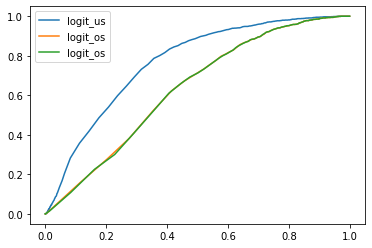

In [11]:
metrics_logit_us = PredMetrics(pred_pd = logit_us.predict_proba(test_df.loc[:,test_df.columns != 'Inactive'])[:,1],
                       actual = np.array(test_df.Inactive))
metrics_logit_os = PredMetrics(pred_pd = logit_os.predict_proba(test_df.loc[:,test_df.columns != 'Inactive'])[:,1],
                       actual = np.array(test_df.Inactive))
metrics_logit_sm = PredMetrics(pred_pd = logit_sm.predict_proba(test_df.loc[:,test_df.columns != 'Inactive'])[:,1],
                       actual = np.array(test_df.Inactive))

thresholds = np.linspace(start=0, stop=1, num=1000)

labels = ['logit_us', 'logit_os', 'logit_sm']
n = 0

for model in [metrics_logit_us, metrics_logit_os, metrics_logit_sm]:
    fpr = [model.fpr(i) for i in thresholds]
    tpr = [model.tpr(i) for i in thresholds]
    plt.plot(fpr, tpr, label = labels[n])
    n =+ 1

plt.legend()
plt.show()

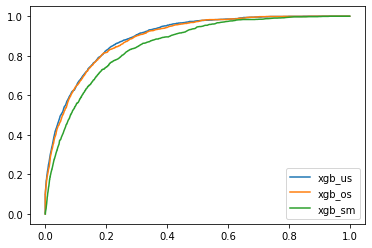

In [12]:
metrics_xgb_us = PredMetrics(pred_pd = xgb_us.predict_proba(np.array(test_df.loc[:,test_df.columns != 'Inactive']))[:,1],
                       actual = np.array(test_df.Inactive))
metrics_xgb_os = PredMetrics(pred_pd = xgb_os.predict_proba(np.array(test_df.loc[:,test_df.columns != 'Inactive']))[:,1],
                       actual = np.array(test_df.Inactive))
metrics_xgb_sm = PredMetrics(pred_pd = xgb_sm.predict_proba(np.array(test_df.loc[:,test_df.columns != 'Inactive']))[:,1],
                       actual = np.array(test_df.Inactive))

thresholds = np.linspace(start=0, stop=1, num=1000)

labels = ['xgb_us', 'xgb_os', 'xgb_sm']
n = 0

for model in [metrics_xgb_us, metrics_xgb_os, metrics_xgb_sm]:
    fpr = [model.fpr(i) for i in thresholds]
    tpr = [model.tpr(i) for i in thresholds]
    plt.plot(fpr, tpr, label = labels[n])
    n += 1

plt.legend()
plt.show()

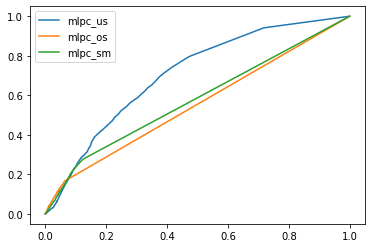

In [13]:
metrics_mlpc_us = PredMetrics(pred_pd = mlpc_us.predict_proba(np.array(test_df.loc[:,test_df.columns != 'Inactive']))[:,1],
                       actual = np.array(test_df.Inactive))
metrics_mlpc_os = PredMetrics(pred_pd = mlpc_os.predict_proba(np.array(test_df.loc[:,test_df.columns != 'Inactive']))[:,1],
                       actual = np.array(test_df.Inactive))
metrics_mlpc_sm = PredMetrics(pred_pd = mlpc_sm.predict_proba(np.array(test_df.loc[:,test_df.columns != 'Inactive']))[:,1],
                       actual = np.array(test_df.Inactive))

thresholds = np.linspace(start=0, stop=1, num=1000)

labels = ['mlpc_us', 'mlpc_os', 'mlpc_sm']
n = 0

for model in [metrics_mlpc_us, metrics_mlpc_os, metrics_mlpc_sm]:
    fpr = [model.fpr(i) for i in thresholds]
    tpr = [model.tpr(i) for i in thresholds]
    plt.plot(fpr, tpr, label = labels[n])
    n += 1

plt.legend()
plt.show()

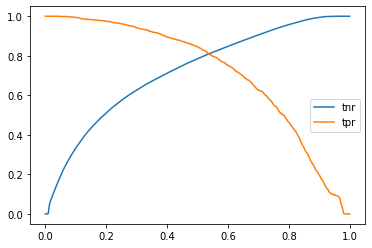

In [14]:
metrics = PredMetrics(pred_pd = xgb_us.predict_proba(np.array(test_df.iloc[:, test_df.columns != 'Inactive']))[:,1],
                       actual = np.array(test_df.Inactive))

thresholds = np.linspace(start=0, stop=1, num=1000)

tnr = [metrics.tnr(i) for i in thresholds]
tpr = [metrics.tpr(i) for i in thresholds]

plt.plot(thresholds, tnr, label = "tnr")
plt.plot(thresholds, tpr, label = "tpr")
plt.legend()
plt.show()

In [15]:
metrics.max_balanced_acc(granularity = 1000)

thresholds      0.497497
tpr             0.847639
tnr             0.783186
balanced_acc    0.815413
Name: 497, dtype: float64